Assignment 2: 

Name: Jeffin Johny Kachappilly

UID: 118293929

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Jeffin Johny


In [10]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage
import matplotlib.pyplot as plt
import time
from scipy import signal
%matplotlib inline

# Part 1: A Feature Tracker (50 Points)

## Overview

In the problem, you will implement a corner detector and feature tracker that track features from the image sequence hotel. Since this is a two part problem, we have included precomputed intermediate results in the *Data* section in case you’re unable to complete any portion.

<img src="https://drive.google.com/uc?id=1sBtKpU2mYEPZ9c2Cvw-DBuLBPK2gYwC-" width="700"/>

**Note:**  Do not use existing keypoint
detectors, trackers, or structure from motion code, such as found on the web, and OpenCV.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [11]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"
!gdown 1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
# Load Initial Key Points
data = loadmat('/content/initial_keypoints.mat')
X0 = data['Xo']
Y0 = data['Yo']

Downloading...
From: https://drive.google.com/uc?id=1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
To: /content/part1_images.zip
100% 5.10M/5.10M [00:00<00:00, 220MB/s]
Archive:  /content/part1_images.zip
replace /content/part1_images/hotel.seq41.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Downloading...
From: https://drive.google.com/uc?id=1r-Pdino6MRLCEWX_sQOgd8D5AVsRc7Ym
To: /content/initial_keypoints.mat
100% 1.61k/1.61k [00:00<00:00, 2.32MB/s]


## Helper Functions

In [12]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    # Reading as grayscale
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png' , 0))
  return np.array(arr_images, dtype=np.float32)

def trackPoints(pt_x, pt_y, im, ws):
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: [Number of keypoints] x [2]
    track_y: [Number of keypoints] x [2]
  '''
  N = np.prod(pt_x.shape)
  nim = len(im)
  ####tuple
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

  for t in range(nim-1):

    track_x[:, t+1], track_y[:, t+1] = getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws )
  return track_x, track_y

# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51) 


## 1.1 Keypoint Selection (15 pts)

For the first frame, use the second moment matrix to locate strong corners to use as keypoints.
These points will be tracked throughout the sequence in the second part of the problem. Choose a proper threshold so that edges and noisy patches are ignored. Do local non-maxima suppression over a 5x5 window centered at each point.
This should give several hundred good points to track.

### Code (5 pts)

<Figure size 432x288 with 0 Axes>

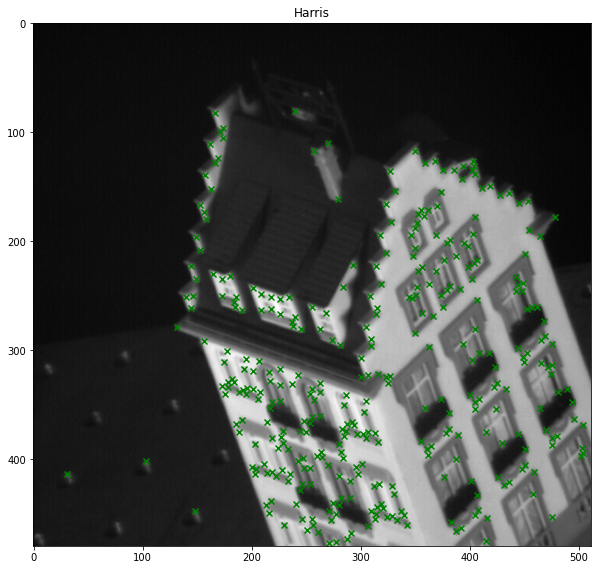

In [13]:
def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  img: input image
  tau: threshold 
  
  output: (N,2) array of [x,y] keypoints
  '''
  # Blur initial image
  image_array = cv2.GaussianBlur(img, (11, 11), 0)

  # Gradient calculation
  grad_y , grad_x  = np.gradient(image_array)

  i_X_2 = grad_x**2
  i_Y_2 = grad_y**2
  iX_iY = grad_x*grad_y

  # Blur of gradients
  blur_i_X_2 = cv2.GaussianBlur(i_X_2, (5, 5), 0)
  blur_i_Y_2 = cv2.GaussianBlur(i_Y_2, (5, 5), 0)
  blur_iX_iY = cv2.GaussianBlur(iX_iY, (5, 5), 0)

  # Appx. Harris score calculation
  har = ( blur_i_X_2*blur_i_Y_2 ) - ( blur_iX_iY**2 ) - 0.04*( (blur_i_X_2+blur_i_Y_2)**2 )   
  har += abs(np.min(har)) 
  har /= np.max(har)

  # Kernel with zero at middle for non-maxima suppression 
  kernel = np.ones((5, 5))
  kernel[2][2] = 0
  img_inter = signal.order_filter(har, kernel, 23)

  # Non - maxima suppression
  img_final = np.where( har>img_inter ,har , 0)
  # Score threshholding
  new_score = np.where(img_final>tau)

  # Making into (x,y) format
  keypoint_2d = np.hstack(( new_score[1].reshape(-1,1) , new_score[0].reshape(-1 , 1)))

  
  return keypoint_2d

# compute keypoints in the first sequence
tau = 0.583
# tau = 0.59
key_pts = getKeypoints(im[0], tau)

plt.figure()
plt.figure(figsize = (10, 10))
plt.title('Harris')
plt.scatter(key_pts[:,0] , key_pts[:,1] , color ='g' , marker ='x') 
plt.imshow(im[0] , cmap = 'gray')

### Write-up (10 pts)


*   (5 pts) Explain your implementation of getKeypoints()
*   (5 pts) Display the first frame of the sequence overlaid with the detected keypoints. Ensure that they are clearly visible (plot with `color='g' and linewidths=3`)



**Include your write-up here**
1.   
   *  The first frame is taken and blurred.
   *  The gradients in both x and y direction of intensities are calculated using np.gradient().
   *  The gradients Ixx, Iyy , Ixy are blurred to remove noise.
   *  The harris score is calculated and the scores are normalised between 0 and 1.
   *  A square matrix with ones of size(5X5) is created and center element is set to 0.
   *  Using this kernel and applying order_filter for getting the second last largest element in a given window(MASK).
   *  The above mask(same size as image) is compared with matrix of normalised harris scores, therby implementing non-maxima suprresion.
   *  Then the new scores are threshholded to limit the number of corners.
   *  FInally scores stacked of the form (x,y).

2. 
[Detected keypoints](https://drive.google.com/file/d/18CoFU7Jaa4SU_aD5BTsvf9Xj7xm_Nz9l/view?usp=sharing)


## 1.2 Feature Tracking (35 pts)

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints found in part 1.1 (or the given keypoints in the *Data* section) throughout the hotel sequence. 

<img src="https://drive.google.com/uc?id=1dU4p4YcnXoQFnrNvleEty_4tDECkVW9Q" width="500"/>

Some keypoints will move out of the image frame over the course of the sequence. Discard any track if the predicted translation falls outside the image frame.

**Hint:**

*  From the 1st frame to the 2nd frame, use the detected keypoints at the first frame as initialization points. From the 2nd to 3rd frame, use the tracked positions at the 2nd frame as initialization. Note that the tracked keypoints in general are not at integer positions.

*  For each point, use a window size of 15 x 15.

Add codes to **plot** your tracked points overlayed in the **first sequence** and the **last sequence**. They should look similar to the second picture shown in the Overview section. 



### Code (10 pts)

<Figure size 432x288 with 0 Axes>

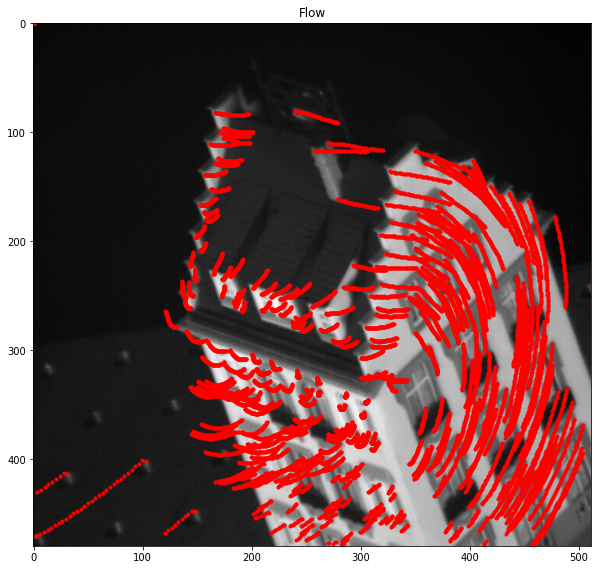

In [14]:
def getNextPoints(x, y, im1, im2, ws ):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im1
  ws: patch window size

  output: tracked keypoint positions in im2
  '''

  hw = np.floor(ws/2)

  track_x = np.zeros(x.shape)
  track_y = np.zeros(y.shape)

  # For each keypoint
  for kp_index in range(len(x)):

    # Getting patch for the current keypoint
    I_im1 = cv2.getRectSubPix(im1 , (ws,ws) ,(x[kp_index], y[kp_index]))

    # Check whether patch out of bounds of the image
    if ((x[kp_index]+hw)>im1.shape[1]) or (-hw+x[kp_index] < 0) or ((y[kp_index]+hw)>im1.shape[0]) or (-hw+y[kp_index]<0):

      out_bounds.append(kp_index)
      track_x[kp_index ] = x[kp_index]
    
      track_y[kp_index ] = y[kp_index]
      break

    # Gradient of valid patch
    Iy_patch , Ix_patch = np.gradient(I_im1)
    Ix_Iy = Iy_patch*Ix_patch

    # Matrix A calculation
    A = np.array([[np.sum(Ix_patch**2) , np.sum(Ix_Iy)],
                  [np.sum(Ix_Iy) , np.sum(Iy_patch**2)]])  

    # For 1st iteration u,v =0
    x_prime = x[kp_index]
    y_prime = y[kp_index]

    # Iterating over each keypoint
    for iterate in range(5):

        It = cv2.getRectSubPix(im2 , (ws,ws) ,(x_prime , y_prime)) - I_im1
 
        # MAtrix 'b' estimation for updated section
        b = np.array([-np.sum(Ix_patch*It) , -np.sum(Iy_patch*It)])

        disp = np.linalg.solve(A,b)
        # Estimated displacement
        u , v = disp
        # Updation
        x_prime = x_prime + u
        y_prime = y_prime + v

    # setting the tracked point in next frame for the current keypoint
    track_x[kp_index ] = x_prime
    track_y[kp_index ] = y_prime

  return track_x , track_y

# track keypoints across the sequences, getNextPoints() is called inside the trackPoints() function
ws = 7

out_bounds = []

tracked_pts = trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)

# plot for entire computed keypoints
x,y = tracked_pts
plt.figure()
plt.figure(figsize = (10, 10))
plt.title('Flow')
plt.scatter(x , y , color ='red' , marker ='.') 
plt.imshow(im[0] , cmap = 'gray')

### Write-up (25 pts)

*   (5 pts) For all the keypoints, display (1) the keypoints at the first frame (as green) and (2) the tracked keypoints at the second frame (as red) on the first frame of the sequence.
*   (10 pts) For 20 random keypoints, draw the 2D path over the sequence of frames. That is, plot the progression of image coordinates for each of the 20 keypoints. Plot each of the paths on the same figure, overlaid on the first frame of the sequence.
*   (10 pts) On top of the first frame, plot the points which have moved out of frame at some point along the sequence.





**Include your write-up here**

<Figure size 432x288 with 0 Axes>

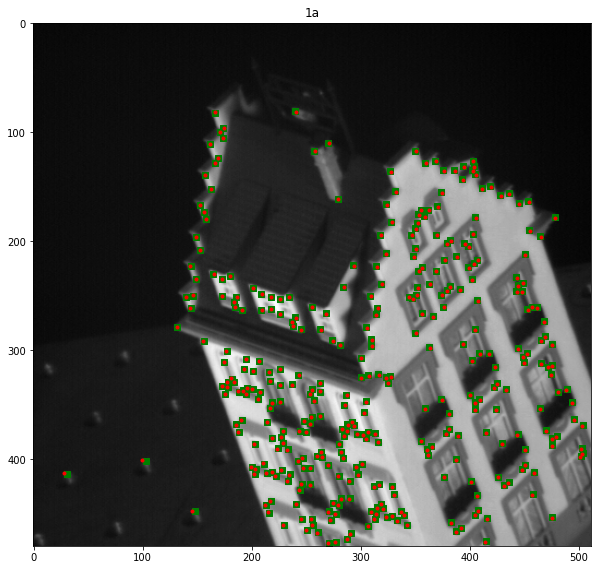

In [15]:
# 1a plot
plt.figure()
plt.figure(figsize = (10, 10))
plt.title('1a')
plt.scatter(x[:,0] , y[:,0] , color ='green' , marker ='s') 
plt.scatter(x[:,1] , y[:,1] , color ='red' , marker ='.') 
plt.imshow(im[0] , cmap = 'gray')

<Figure size 432x288 with 0 Axes>

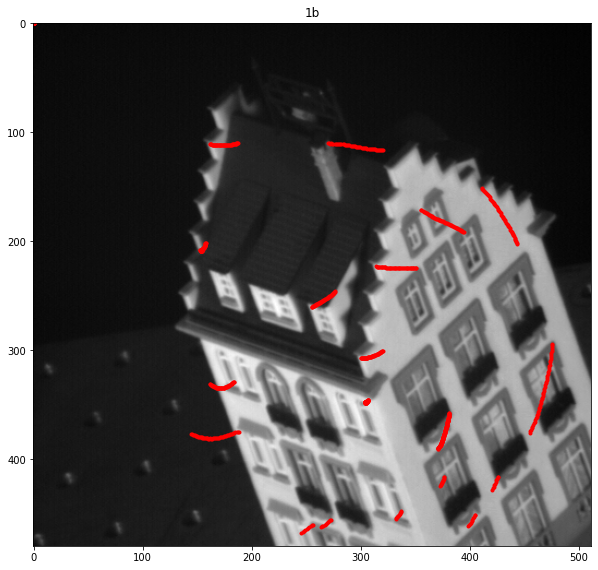

In [16]:
# 1b plot
index_random = np.random.randint(0, x.shape[0] , 20)

plt.figure()
plt.figure(figsize = (10, 10))
plt.title('1b')

plt.scatter(x[index_random,:] , y[index_random,:] , color ='red' , marker ='.') 
plt.imshow(im[0] , cmap = 'gray')

<Figure size 432x288 with 0 Axes>

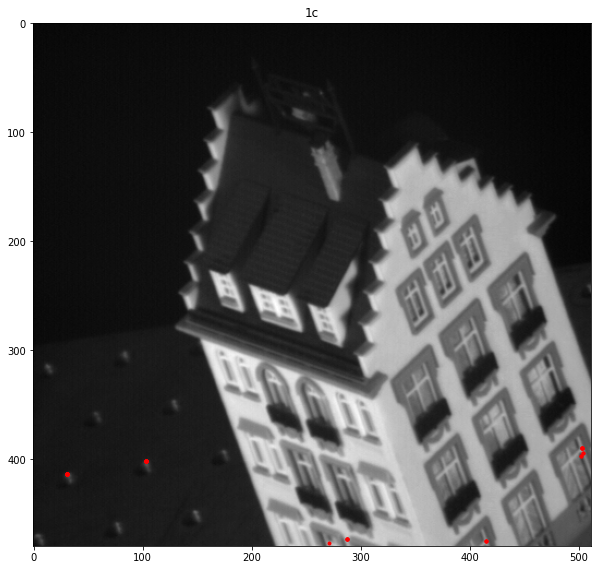

In [17]:
# 1c plot
plt.figure()
plt.figure(figsize = (10, 10))
plt.title('1c')

for element in out_bounds:
    plt.scatter(x[element,0] , y[element,0] , color ='red' , marker ='.') 

plt.imshow(im[0] , cmap = 'gray')

# Part 2: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using global image transformation (similarity, affine, or perspective) and returns $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$. You may choose the alignment algorithm and the type of (global) transformation (e.g., rigid Euclidean, affine, perspective).


<img src="https://drive.google.com/uc?id=1PnWIy9ZdP9SGkmGNtFCJ-JzKLwmW-qaN" width="1000"/>

Test your code on the 25 image pairs provided in the supplementary material. We have included functions 
**(will check) evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [18]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
To: /content/part2_images.zip
100% 78.4k/78.4k [00:00<00:00, 29.6MB/s]
Archive:  /content/part2_images.zip
   creating: /content/part2_images/
 extracting: /content/part2_images/Bone_1.png  
 extracting: /content/part2_images/elephant_1.png  
 extracting: /content/part2_images/brick_2.png  
 extracting: /content/part2_images/Heart_2.png  
 extracting: /content/part2_images/Bone_2.png  
  inflating: /content/part2_images/elephant_2.png  
 extracting: /content/part2_images/brick_1.png  
 extracting: /content/part2_images/Heart_1.png  
  inflating: /content/part2_images/device7_1.png  
  inflating: /content/part2_images/device7_2.png  
 extracting: /content/part2_images/fork_2.png  
 extracting: /content/part2_images/turtle_2.png  
  inflating: /content/part2_images/fork_1.png  
 extracting: /content/part2_images/turtle_1.png  
 extracting: /content/part2_images/butterfly_2.png  
 extracting: /content/pa

## Helper Functions

In [19]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x) 
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time 
     thick: true if a line should be thickened for display
  ''' 
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim
  

## Code (15 pts)

In [20]:
def rotate(x,y):
    """rotates the points by 120 and 240 degrees

    Args:
        x (numpy array): x coordinates where the pixels are white
        y (numpy array): y coordinates where the pixels are white

    Returns:
        _type_: 4 numpy array
    """    
    x_120 = x*np.cos((2/3)*np.pi) + y*np.sin((2/3)*np.pi)
    y_120 = -x*np.sin((2/3)*np.pi) + y*np.cos((2/3)*np.pi)  

    x_240 = x*np.cos(-(2/3)*np.pi) + y*np.sin(-(2/3)*np.pi)
    y_240 = -x*np.sin(-(2/3)*np.pi) + y*np.cos(-(2/3)*np.pi)  

    return x_120 , y_120 , x_240 , y_240


def multiple_ini( x , y):
    """Multiple initializations

    Args:
        x (numpy array): x coordinates where the pixels are white
        y (numpy array): y coordinates where the pixels are white

    Returns:
        _type_: list[]
    """    
    possibility = []
    possibility.append( (x,y) )
    # New images after rotation of original image
    x_120 , y_120 , x_240 , y_240 = rotate(x, y)

    possibility.append( (x_120,y_120) )
    possibility.append( ( x_240,y_240) )

    # Flipping original image vertically 
    lr_flip_x = -x
    lr_flip_y = y

    # New images after rotation of flipped image
    x_lr_120 , y_lr_120 , x_lr_240 , y_lr_240 = rotate(lr_flip_x, lr_flip_y)

    possibility.append( (lr_flip_x,lr_flip_y) )
    possibility.append( (x_lr_120,y_lr_120) )
    possibility.append( (x_lr_240,y_lr_240) )    

    # Flipping original image horizontaly 
    ud_flip_x = x
    ud_flip_y = -y
    # New images after rotation of flipped image
    x_ud_120 , y_ud_120 , x_ud_240 , y_ud_240 = rotate(ud_flip_x, ud_flip_y)

    possibility.append( (ud_flip_x,ud_flip_y) )
    possibility.append( (x_ud_120,y_ud_120) )
    possibility.append( (x_ud_240,y_ud_240) )   

    return possibility   

In [21]:
def align_shape(im1, im2):
  '''
  im1: input edge image 1
  im2: input edge image 2

  Output: x and y coordinates of aligned image
  
  '''
  im1_points_y , im1_points_x = np.where(im1 == 255)

  # Multiple Initializations
  diff_orien = multiple_ini(im1_points_x , im1_points_y)

  after_transform = []

  # Array for storing the minimum distance after transformations for each initialization
  # of image
  min_dist_identifier = np.zeros( len(diff_orien) )

  # For each initialization
  for list_index , element in enumerate(diff_orien):
    
    im1_points_x  =element[0]
    im1_points_y = element[1]
    # Mean of points for current initialization of image
    im1_mean_x = np.mean(im1_points_x)
    im1_mean_y = np.mean(im1_points_y)

    im2_points_y , im2_points_x = np.where(im2 == 255)
    im2_mean_x = np.mean(im2_points_x)
    im2_mean_y = np.mean(im2_points_y)

    # Computing translational distance between both image
    mean_x_diff = im2_mean_x - im1_mean_x
    mean_y_diff = im2_mean_y - im1_mean_y

    # Image translated
    im1_trans_x = mean_x_diff + im1_points_x
    im1_trans_y = mean_y_diff + im1_points_y

    im2_points = np.hstack(( im2_points_x.reshape(-1,1) , im2_points_y.reshape(-1 , 1)))
  
    x  = im1_trans_x
    y =  im1_trans_y 
    # Number of iterations for each image
    runs = 15

    for iterate in range(runs):

      im1_points_trans = np.hstack(( x.reshape(-1,1) , y.reshape(-1 , 1)))
      num_pts_im1 = im1_points_trans.shape[0]
      num_pts_im2 = im2_points.shape[0]
      # Initializing distance matrix 
      dists = np.zeros((num_pts_im1, num_pts_im2))
      # The expansion of (a-b^2) = a^2 - 2*a*b + b^2, Is used for distance.
      # Transposing training data to follow the rules of matrix multiplication
      ip2_correct_form = np.transpose(im2_points)
      
      # Broadcasting of two sums takes place. 
      # For 'X**2' component, keepdims had to be set to true to follow the 
      # compatibility rules for broadcasting
      dists = np.sqrt(np.sum(im1_points_trans**2, axis = 1, keepdims=True) 
              - 2*np.matmul(im1_points_trans , ip2_correct_form) 
              + np.sum(im2_points**2, axis = 1))

      # Getting indices with minimum distance
      nearest_indices = np.argmin(dists , axis = 1)

      x_p = np.zeros(im1_points_trans.shape[0])
      y_p = np.zeros(im1_points_trans.shape[0])

      for index in range(nearest_indices.shape[0]):
        # Getting nearest neighbours from img2 for current orientation of img1
        x_p[index] = im2_points[nearest_indices[index],0]
        y_p[index] = im2_points[nearest_indices[index],1]


      AA = np.zeros((2*num_pts_im1 , 6))
      bb = np.zeros((2*num_pts_im1 , 1))
      # Matrix determined for Affine Transformation
      for i in range(0 , num_pts_im1):

        AA_i = np.array([[x[i] , y[i] , 0 , 0 , 1 ,0]
                        ,[0 , 0  , x[i] , y[i] , 0 , 1]]).reshape(2 , 6)

        bb_i = np.array([[x_p[i]] ,
                          [y_p[i]]])

        AA[2*i : 2*i+2 , :] = AA_i
        bb[2*i : 2*i+2 , :] = bb_i

      At_A = np.matmul(AA.T , AA)
      Rhs = np.matmul(AA.T , bb)
      At_A_inv = np.linalg.inv(At_A)

      # Transformation matrix calculated
      parameters = np.matmul(At_A_inv , Rhs)

      # Transformation matrix for multiplication on img1 points (2X2)
      T_1 = np.array([[parameters[0,0] , parameters[1,0]],
                      [parameters[2,0] , parameters[3,0]] ])

      # T matrix for addition to img1 points (2X1)
      T_2 = np.array([[parameters[4,0] ],
                      [parameters[5,0] ] ])

      # Transforming the points and making those as points of image 1
      for number in range(num_pts_im1):

        transformed_pt= np.matmul(T_1 , np.array([ [x[number]] , [y[number]] ]))
        transformed_pt = transformed_pt + T_2

        x[number] = transformed_pt[0]
        y[number] = transformed_pt[1]

      # Only implemented at last run of iteration
      if iterate == runs - 1 :
        # total Minimum distance between current img1 points and nearest 
        # neighfbours of img2 
        min_dists = np.min(dists , axis =1 )

        min_dist_identifier[list_index ] = np.sum(min_dists)
        # Storing the transformed of current initializaton
        after_transform.append( (x, y) )

  # Choosing the initialization with smallest sum of NN distance
  right_choice = np.argmin(min_dist_identifier)

  x = after_transform[right_choice][0]
  y = after_transform[right_choice][1]

  return x , y

In [22]:
imgPath = '/content/part2_images/'
# imgPath = 'part2_images/'

objList = ['apple', 'bat', 'bell', 'bird', 'Bone', 'bottle', 'brick', 
    'butterfly', 'camel', 'car', 'carriage', 'cattle', 'cellular_phone', 
    'chicken', 'children', 'device7', 'dog', 'elephant', 'face', 'fork', 'hammer', 
    'Heart', 'horse', 'jar', 'turtle']

numObj = len(objList)

def answer(list_item):
    start = time.time()
    im1 = cv2.imread(f'{imgPath}{objList[list_item]}_1.png' , 0)
    im2 = cv2.imread(f'{imgPath}{objList[list_item]}_2.png' , 0)

    #Calling alignment function
    x,y = align_shape(im1 , im2)

    # Image for visualizing aligned
    blank_image = np.zeros((im1.shape), np.uint8)

    # Updating the points
    for index in range(x.shape[0]):
        if x[index]<blank_image.shape[1] and y[index]<blank_image.shape[0]:
            blank_image[int(y[index]) , int(x[index])] = 255


    plt.figure()
    plt.figure(figsize = (15, 15))
    plt.subplot(1,3,1),plt.imshow(im1,cmap = 'gray')
    plt.title('Image 1')
    plt.axis('off')
    plt.subplot(1,3,2),plt.imshow(im2,cmap = 'gray')
    plt.title('Image 2')
    plt.axis('off')
    plt.subplot(1,3,3),plt.imshow(blank_image ,cmap = 'gray')
    plt.title('Aligned image 1')
    plt.axis('off')
    end =time.time()

    name = objList[list_item].upper()


    print(f"Runtime for image {name} - {end-start}s")

    error =evalAlignment(blank_image , im2)
    print(f"Final error after Alignment for image {name} - {error}")



## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation.

2. (10 pts) For each result, give:
  1.   The alignment display
  2.   The final error
  3.   The runtime






:**Include your write-up here**

 1.
  * Initialization : Each image is mirrored along the x and y axeses. And each one of the previous image is rotated 120 and 240 degrees. Therby each list element have 9 images.
  * Model of Transformation: In this problem the affine transformation is implemented(6X1). The points are first multiplied by a square matrix of size (2X2) , first 4 elements of transformation matrix. And followed by the translation of those points using the remaining 2 elements of transformation matrix.
  * Algorithm: 
     - Multiple initialization of given image.
     - And for each initialise, the mean is computed between current img and img2.
     - The points are translated, and nearest neighbor is determined for each pixel location of current instance
     - Using those nearest neighbors as final location, the Transformation matrix is computed.
     - And the points are transformed to those locations.
     - This is iterated a couple of times, for a given initialization of an image.
     - At the last iteration, the sum of min dist is determined for that particular initialization and the points stored.
     - Similarly, the sum of dist is calculated for all 9 initializations and set of points with least sum value is stored as the aligned coordinates. 

Runtime for image APPLE - 3.8107216358184814s
Final error after Alignment for image APPLE - 177.6029020744851


<Figure size 432x288 with 0 Axes>

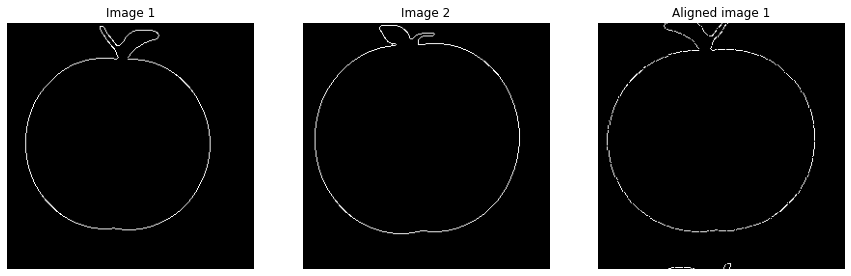

In [23]:
answer(0)

Runtime for image BAT - 12.537022113800049s
Final error after Alignment for image BAT - 423.496130412467


<Figure size 432x288 with 0 Axes>

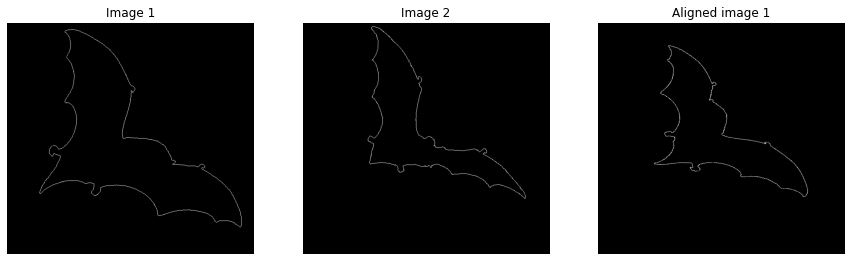

In [24]:
answer(1)

Runtime for image BELL - 2.7607977390289307s
Final error after Alignment for image BELL - 178.3486129403504


<Figure size 432x288 with 0 Axes>

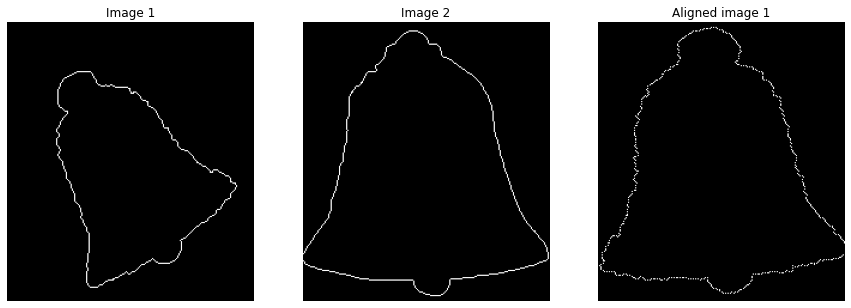

In [25]:
answer(2)

Runtime for image BIRD - 6.464766263961792s
Final error after Alignment for image BIRD - 238.90120474470467


<Figure size 432x288 with 0 Axes>

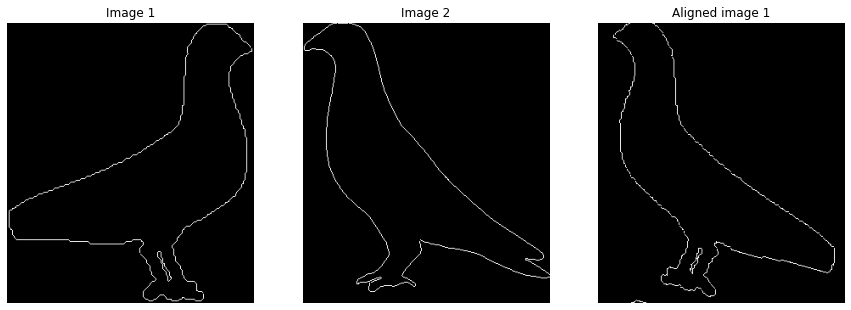

In [26]:
answer(3)

Runtime for image BONE - 6.431988000869751s
Final error after Alignment for image BONE - 320.48423801307104


<Figure size 432x288 with 0 Axes>

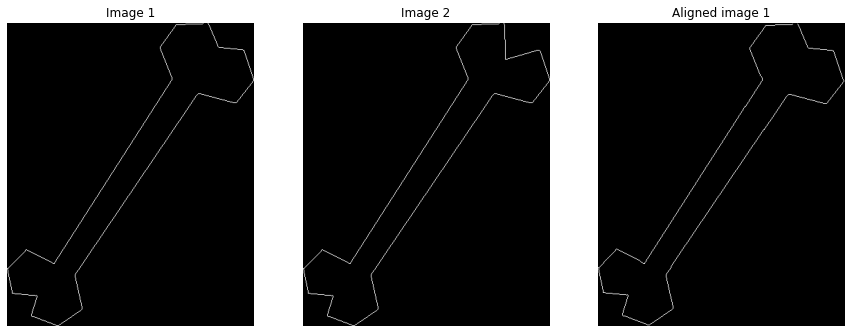

In [27]:
answer(4)

Runtime for image BOTTLE - 1.5585312843322754s
Final error after Alignment for image BOTTLE - 246.29194046415253


<Figure size 432x288 with 0 Axes>

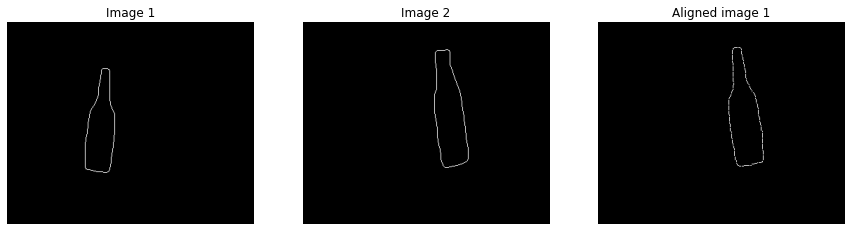

In [28]:
answer(5)

Runtime for image BRICK - 2.5263006687164307s
Final error after Alignment for image BRICK - 303.5793770713814


<Figure size 432x288 with 0 Axes>

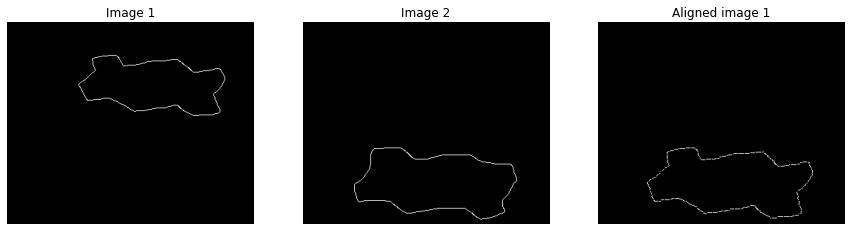

In [29]:
answer(6)

Runtime for image BUTTERFLY - 6.5830466747283936s
Final error after Alignment for image BUTTERFLY - 218.37011289219674


<Figure size 432x288 with 0 Axes>

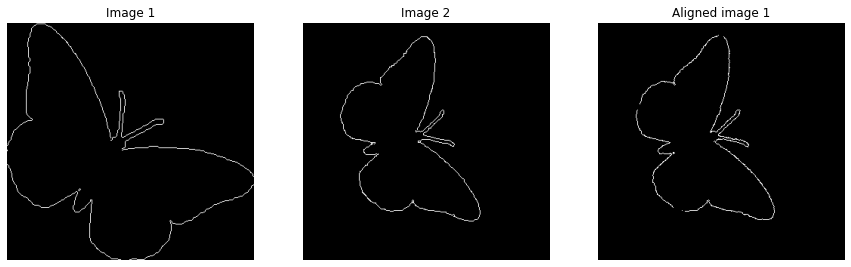

In [30]:
answer(7)

Runtime for image CAMEL - 8.479014158248901s
Final error after Alignment for image CAMEL - 269.980774386931


<Figure size 432x288 with 0 Axes>

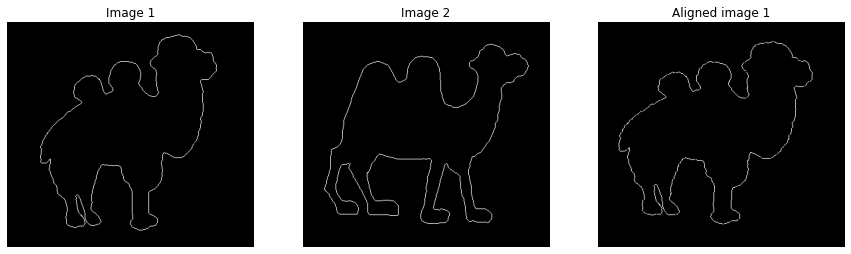

In [31]:
answer(8)

Runtime for image CAR - 2.1699371337890625s
Final error after Alignment for image CAR - 242.4075191290168


<Figure size 432x288 with 0 Axes>

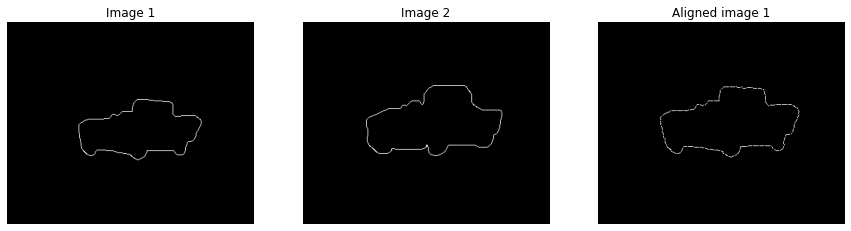

In [32]:
answer(9)

Runtime for image CARRIAGE - 3.7726693153381348s
Final error after Alignment for image CARRIAGE - 284.0164625031956


<Figure size 432x288 with 0 Axes>

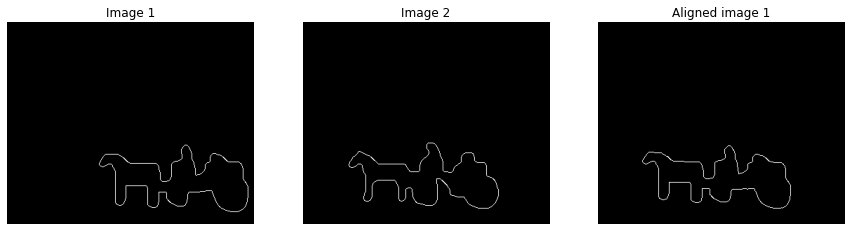

In [33]:
answer(10)

Runtime for image CATTLE - 23.60658097267151s
Final error after Alignment for image CATTLE - 392.4388056354591


<Figure size 432x288 with 0 Axes>

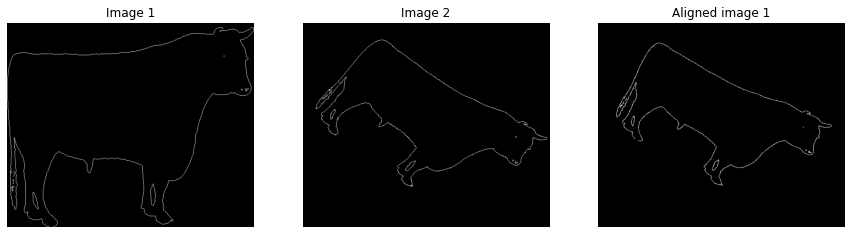

In [34]:
answer(11)

Runtime for image CELLULAR_PHONE - 6.410496234893799s
Final error after Alignment for image CELLULAR_PHONE - 260.82801512146


<Figure size 432x288 with 0 Axes>

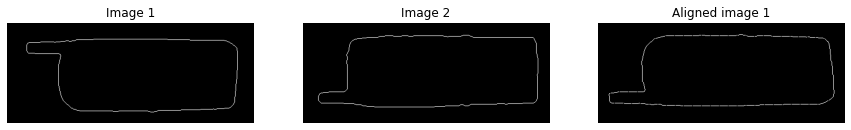

In [35]:
answer(12)

Runtime for image CHICKEN - 3.977656841278076s
Final error after Alignment for image CHICKEN - 146.35922199822244


<Figure size 432x288 with 0 Axes>

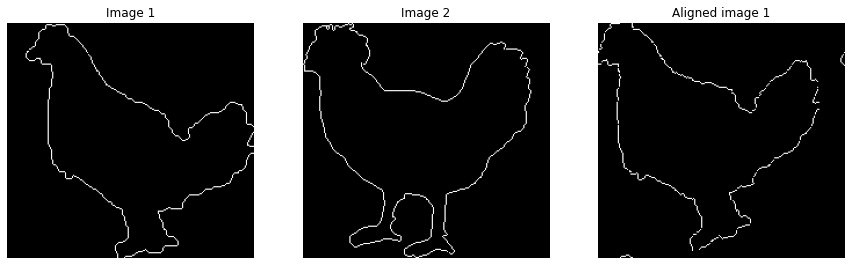

In [36]:
answer(13)

Runtime for image CHILDREN - 1.8414762020111084s
Final error after Alignment for image CHILDREN - 155.8622305578642


<Figure size 432x288 with 0 Axes>

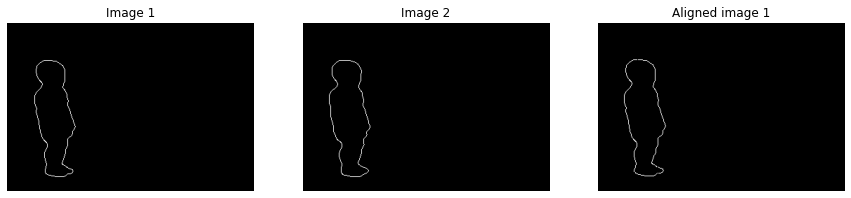

In [37]:
answer(14)

Runtime for image DEVICE7 - 31.815160989761353s
Final error after Alignment for image DEVICE7 - 382.8040077529902


<Figure size 432x288 with 0 Axes>

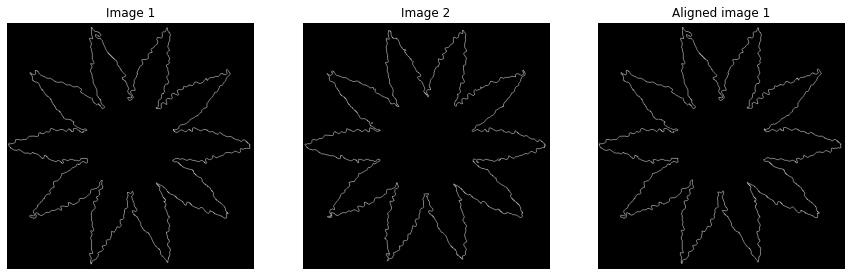

In [38]:
answer(15)

Runtime for image DOG - 17.607015371322632s
Final error after Alignment for image DOG - 353.7343163472034


<Figure size 432x288 with 0 Axes>

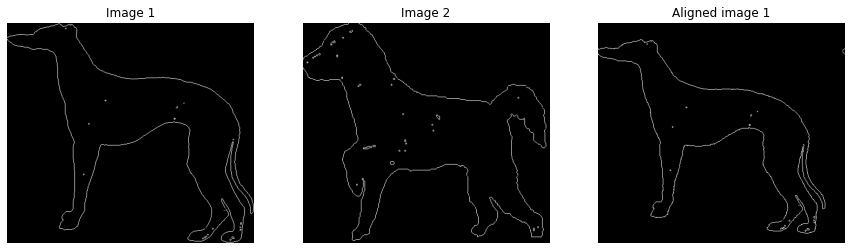

In [39]:
answer(16)

Runtime for image ELEPHANT - 27.841169834136963s
Final error after Alignment for image ELEPHANT - 557.8085997655929


<Figure size 432x288 with 0 Axes>

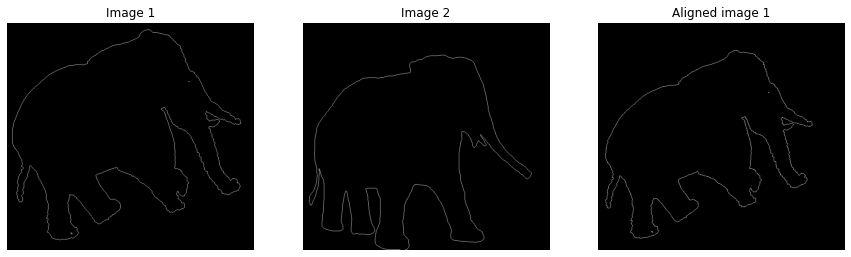

In [40]:
answer(17)

Runtime for image FACE - 4.274354696273804s
Final error after Alignment for image FACE - 232.5353270482938


<Figure size 432x288 with 0 Axes>

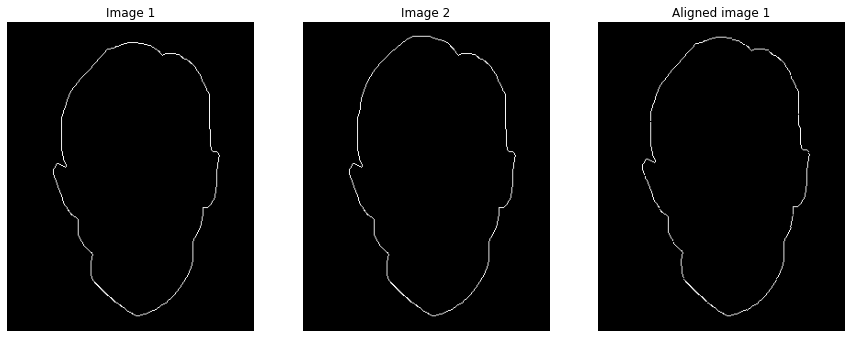

In [41]:
answer(18)

Runtime for image FORK - 13.405979871749878s
Final error after Alignment for image FORK - 359.3390488291684


<Figure size 432x288 with 0 Axes>

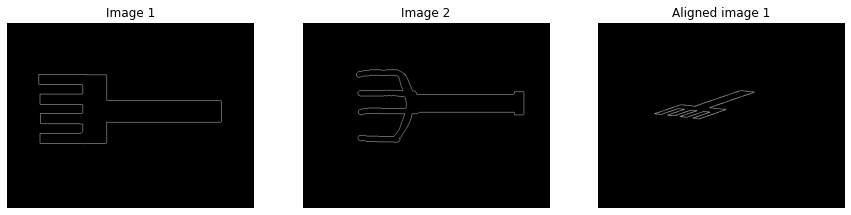

In [42]:
answer(19)

Runtime for image HAMMER - 2.9357492923736572s
Final error after Alignment for image HAMMER - 165.2270696256905


<Figure size 432x288 with 0 Axes>

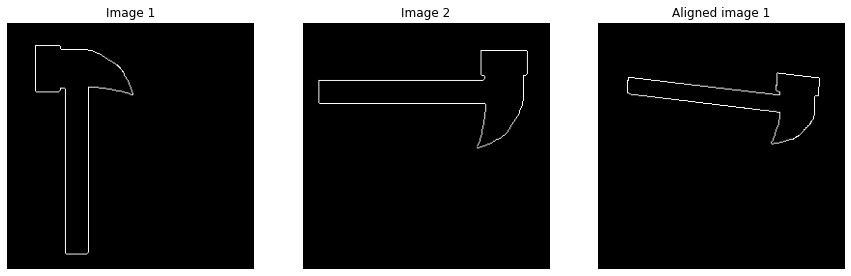

In [43]:
answer(20)

Runtime for image HEART - 8.10021448135376s
Final error after Alignment for image HEART - 316.1502351227831


<Figure size 432x288 with 0 Axes>

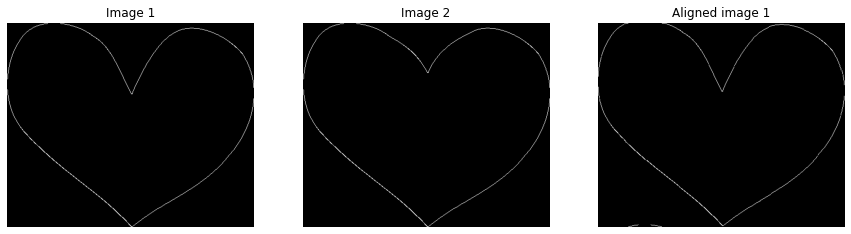

In [44]:
answer(21)

Runtime for image HORSE - 28.884297370910645s
Final error after Alignment for image HORSE - 494.4338578879052


<Figure size 432x288 with 0 Axes>

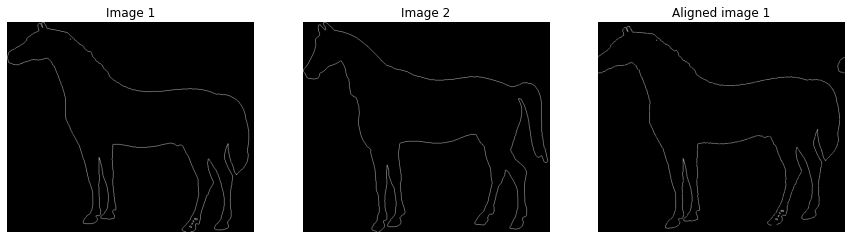

In [45]:
answer(22)

Runtime for image JAR - 13.524349451065063s
Final error after Alignment for image JAR - 364.3327220653748


<Figure size 432x288 with 0 Axes>

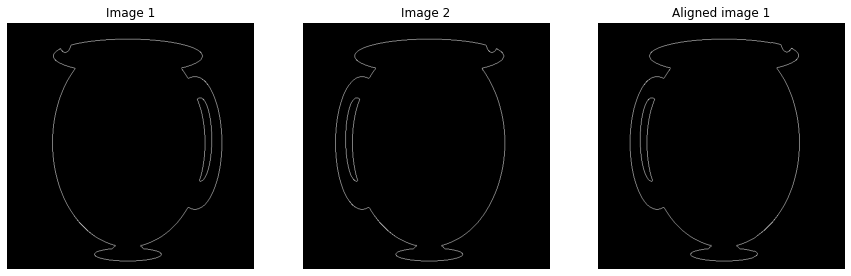

In [46]:
answer(23)

Runtime for image TURTLE - 5.762174606323242s
Final error after Alignment for image TURTLE - 258.93419837517285


<Figure size 432x288 with 0 Axes>

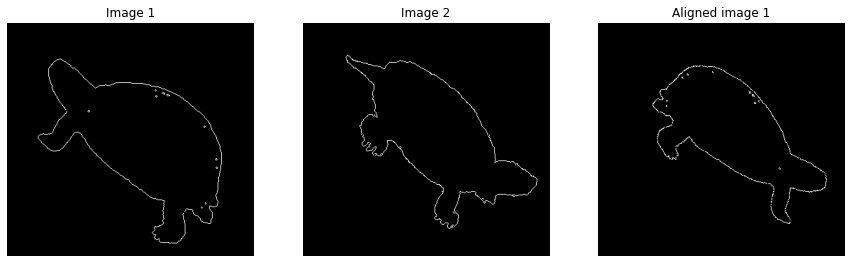

In [47]:
answer(24)

# Part 3: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://drive.google.com/uc?id=1mULTvHYeP5uj_vi7nwWThBHkDbv1eSue" width="1000"/>



## Data

In [48]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

Downloading...
From: https://drive.google.com/uc?id=10ByzpFbB-z178VGjwmCwc95wInD8vpNM
To: /content/SIFT_features.mat
100% 347k/347k [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU
To: /content/stop1.jpg
100% 15.6k/15.6k [00:00<00:00, 22.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J
To: /content/stop2.jpg
100% 224k/224k [00:00<00:00, 91.6MB/s]


## Code (10 pts)

<Figure size 432x288 with 0 Axes>

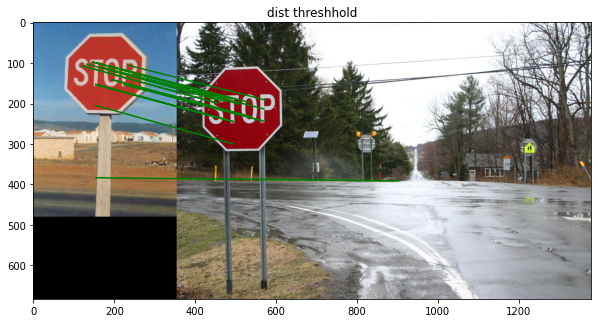

<Figure size 432x288 with 0 Axes>

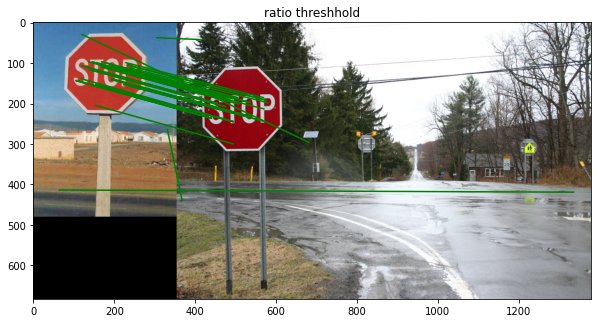

In [49]:
img1 = cv2.imread('/content/stop1.jpg')
img2 = cv2.imread('/content/stop2.jpg')


RGB_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
RGB_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')

Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']

# Converting descriptor type to avoid clipping, whike calculating SSD
im1_points = Descriptor1.T.astype('float')
im2_points = Descriptor2.T.astype('float')

num_pts_im1 = im1_points.shape[0]
num_pts_im2 = im2_points.shape[0]
dists = np.zeros((num_pts_im1, num_pts_im2))
# The expansion of (a-b^2) = a^2 - 2*a*b + b^2, Is used for distance.
# Transposing training data to follow the rules of matrix multiplication
ip2_correct_form = np.transpose(im2_points)

# Broadcasting of two sums takes place. 
# For 'X**2' component, keepdims had to be set to true to follow the 
# compatibility rules for broadcasting

dists = np.sum(im1_points**2, axis = 1, keepdims=True) - 2*np.matmul(im1_points , ip2_correct_form) + np.sum(im2_points**2, axis = 1)


im2_nearest_x = np.zeros(Frame1.shape[1] )
im2_nearest_y = np.zeros(Frame1.shape[1] )

# Storing minimum distances and its indices
nearest_indices = np.argmin(dists , axis = 1)
min_dist_im1 = np.min(dists , axis = 1)

# Finding the nearest neighbor
for indices in range(Frame1.shape[1]):
    im2_nearest_x[indices ] = Frame2[0 , nearest_indices[indices]]
    im2_nearest_y[indices ] = Frame2[1 , nearest_indices[indices]]

# Image which contains img1 and img2
blank_image = np.zeros((img2.shape[0] , img1.shape[1]+img2.shape[1] , 3), np.uint8)
blank_image[:img1.shape[0] , :img1.shape[1]] = RGB_img1
blank_image[:img2.shape[0] , img1.shape[1]:] = RGB_img2

# Distance threshholding
thresh_ssd = 12570

plt.figure()
plt.figure(figsize = (10, 10))
plt.title('dist threshhold')
for i in range(min_dist_im1.shape[0]):
    if min_dist_im1[i]<thresh_ssd:
        plt.plot([Frame1[0,i] , im2_nearest_x[i]+img1.shape[1]] , [Frame1[1,i] , im2_nearest_y[i]] , color = 'green')

plt.imshow(blank_image, cmap = 'gray')



sorted_indices = np.argsort(dists , axis = 1)
# Storing indices for nearest neighbors
f1_f2_indices = sorted_indices[: , 0] 
# Storing indices for second nearest neighbors
f1_f2_prime_indices = sorted_indices[: , 1] 

# Ratio threshholding
thresh_ratio = 0.55

plt.figure()
plt.figure(figsize = (10, 10))
plt.title('ratio threshhold')
for i in range(min_dist_im1.shape[0]):
    Nr = dists[i ,  f1_f2_indices[i] ]
    Dr = dists[i , f1_f2_prime_indices[i ]]
    # Ratio determination
    if ( (Nr/Dr)<thresh_ratio ):
        plt.plot([Frame1[0,i] , im2_nearest_x[i]+img1.shape[1]] , [Frame1[1,i] , im2_nearest_y[i]] , color = 'green')

plt.imshow(blank_image, cmap = 'gray')


## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances.

2. the matches by thresholding the distance ratio. 

(5 pts) Describe the differences of (1) and (2).

**Your answer here**
1. Refer output plot.
2. Refer output plot.

3. 

Both distance and ratio works without problems on images with a variety of textures. But when an image has same repeated patterns, the classifier can misinterpret the blob location. In that scenario, distance threshhold fails miserably and the way to work around is using ratio threshholding. As the ratio is computed using nearest and second nearest neighbors, the ratio with larger values can be disregarded.

Here the distance thresh has low number of matched keypoints compared to ratio, due to the effect explained above on the red stop sign.